- case3: case2 정상 언더샘플링 & 중증 오버샘플링 & standard scaler

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import os
import warnings

warnings.filterwarnings("ignore")

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [11]:
n_splits = 3
random_seed = 2025

# Data

In [12]:
train_sleep_file_path = "../data/train/raw/train_sleep.csv"
train_activity_file_path = "../data/train/raw/train_activity.csv"
train_label_file_path = "../data/train/label/1.걸음걸이/training_label.csv"

test_sleep_file_path = "../data/validation/raw/val_sleep.csv"
test_activity_file_path = "../data/validation/raw/val_activity.csv"
test_label_file_path = "../data/validation/label/1.걸음걸이/val_label.csv"

train_derived_file_path = "../data/derived_var/train_add.csv"
test_derived_file_path = "../data/derived_var/validation_add.csv"

train2_derived_file_path = "../data/derived_var/bong_train.csv"
test2_derived_file_path = "../data/derived_var/bong_validation.csv"

train3_derived_file_path = "../data/derived_var/sleep_train_add1.csv"
test3_derived_file_path = "../data/derived_var/sleep_validation_add1.csv"

In [13]:
train_label = pd.read_csv(train_label_file_path)
train_sleep = pd.read_csv(train_sleep_file_path)
train_activity = pd.read_csv(train_activity_file_path)

test_label = pd.read_csv(test_label_file_path)
test_sleep = pd.read_csv(test_sleep_file_path)
test_activity = pd.read_csv(test_activity_file_path)

train_derived = pd.read_csv(train_derived_file_path)
test_derived = pd.read_csv(test_derived_file_path)

train_derived2 = pd.read_csv(train2_derived_file_path)
test_derived2 = pd.read_csv(test2_derived_file_path)
test_derived2.drop(["Unnamed: 0"], inplace=True, axis=1)

train_derived3 = pd.read_csv(train3_derived_file_path)
test_derived3 = pd.read_csv(test3_derived_file_path)

In [14]:
# train, test email exclusive 확인
common_elements = list(
    set(train_label["SAMPLE_EMAIL"]) & set(test_label["SAMPLE_EMAIL"])
)
len(common_elements)

0

In [15]:
# sleep + label
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
train.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)
test.drop(["SAMPLE_EMAIL"], axis=1, inplace=True)

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

In [16]:
train["activity_date"] = pd.to_datetime(train["activity_day_start"]).dt.date.astype(str)
test["activity_date"] = pd.to_datetime(test["activity_day_start"]).dt.date.astype(str)

In [17]:
train = train.merge(train_derived, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived, on=["EMAIL", "activity_date"], how="inner")

In [18]:
train = train.merge(train_derived3, on=["EMAIL", "activity_date"], how="inner")
test = test.merge(test_derived3, on=["EMAIL", "activity_date"], how="inner")

In [19]:
train = pd.concat(
    [train, train_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)
test = pd.concat(
    [test, test_derived2.drop(["EMAIL", "activity_day_start"], axis=1)], axis=1
)

In [20]:
for col in train.columns:
    if "_x" in col:
        train.drop([col], axis=1, inplace=True)
        train.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        train.drop([col], axis=1, inplace=True)
    if "std_" in col:
        train.drop([col], axis=1, inplace=True)

for col in test.columns:
    if "_x" in col:
        test.drop([col], axis=1, inplace=True)
        test.rename(
            columns={col.replace("_x", "_y"): col.replace("_x", "")}, inplace=True
        )
    if "avg_" in col:
        test.drop([col], axis=1, inplace=True)
    if "std_" in col:
        test.drop([col], axis=1, inplace=True)

In [21]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [22]:
train["label"] = train["DIAG_NM"].map(label_encoder)
test["label"] = test["DIAG_NM"].map(label_encoder)
train.drop(["DIAG_NM"], axis=1, inplace=True)
test.drop(["DIAG_NM"], axis=1, inplace=True)

# 데이터 다운캐스팅

In [23]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


train = downcast(train)
test = downcast(test)

56.5% 압축됨
56.9% 압축됨


# 데이터 나누기

In [24]:
X_test = test
y_test = test["label"]

In [25]:
train.shape, X_test.shape, y_test.shape

((9704, 194), (2478, 194), (2478,))

# Train, Test 데이터 Exclusive 검증

In [26]:
set(train['EMAIL']) & set(X_test['EMAIL'])

set()

# DIAG_NM(label) 비율

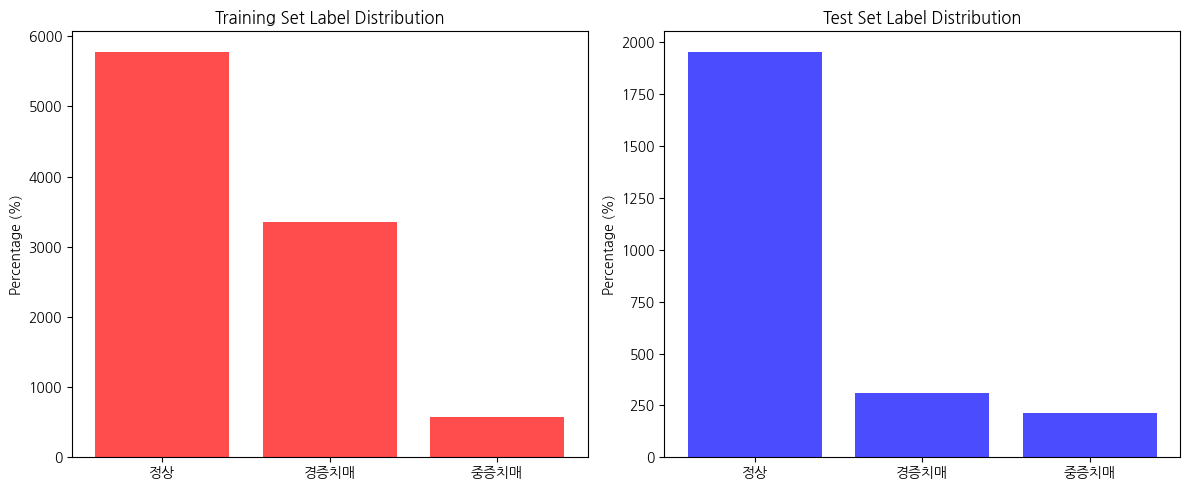

In [27]:
import matplotlib.pyplot as plt

class_distribution_train = train["label"].value_counts()
class_distribution_test = test["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(
    class_distribution_train.index,
    class_distribution_train.values,
    color="red",
    alpha=0.7,
)
axes[0].set_xlabel(None)
axes[0].set_ylabel("Percentage (%)")
axes[0].set_title("Training Set Label Distribution")
axes[0].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

axes[1].bar(
    class_distribution_test.index,
    class_distribution_test.values,
    color="blue",
    alpha=0.7,
)
axes[1].set_xlabel(None)
axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Test Set Label Distribution")
axes[1].set_xticks([0, 1, 2], ["정상", "경증치매", "중증치매"])

plt.tight_layout()
plt.show()

# 모델 학습 및 성능 검증

In [31]:
from sklearn.tree import DecisionTreeClassifier

# 모델 학습 및 평가
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
}

In [28]:
selected_features = [
    'activity_average_met_30d_avg', 
    'activity_average_met_7d_avg', 
    'activity_average_met_lag2',
    'activity_average_met_lag3',
    'activity_cal_active',
    'activity_cal_total',
    'activity_high',
    'activity_inactive_30d_avg',
    'activity_inactive_7d_avg',
    'activity_inactive_lag2',
    'activity_inactive_lag3',
    'activity_low',
    'activity_met_min_inactive',
    'activity_met_min_medium',
    'activity_rest',
    'activity_score',
    'activity_score_meet_daily_targets',
    'activity_score_training_volume',
    'awake_longest_duration_30d_avg',
    'awake_longest_duration_3d_avg',
    'daytime',
    'evening', 
    'evening_ratio_30d_avg', 
    'evening_ratio_7d_avg', 
    'evening_ratio_lag3', 
    'hr_entropy_0_90', 
    'hr_pattern_3', 
    'met_mean_10_14', 
    'morning', 
    'morning_ratio_30d_avg', 
    'morning_ratio_7d_avg', 
    'night', 
    'rmssd_mean_0_90', 
    'rmssd_rmsd_0_90', 
    'sleep_alignment_chronotype', 
    'sleep_awake_ratio_30d_avg', 
    'sleep_awake_ratio_3d_avg', 
    'sleep_awake_ratio_7d_avg', 
    'sleep_awake_ratio_lag2', 
    'sleep_awake_ratio_lag3', 
    'sleep_breath_average',
    'sleep_consistency', 
    'sleep_consistency_30d_avg', 
    'sleep_consistency_3d_avg', 
    'sleep_consistency_7d_avg', 
    'sleep_consistency_lag2', 
    'sleep_consistency_lag3', 
    'sleep_deep_ratio_30d_avg', 
    'sleep_deep_ratio_7d_avg', 
    'sleep_hr_average',
    'sleep_hr_lowest_30d_avg', 
    'sleep_hr_lowest_3d_avg',
    'sleep_hr_lowest_7d_avg', 
    'sleep_light', 
    'sleep_light_ratio_30d_avg', 
    'sleep_light_ratio_7d_avg',
    'sleep_light_ratio_lag3', 
    'sleep_rem_ratio', 
    'sleep_rem_ratio_30d_avg',
    'sleep_rem_ratio_7d_avg',
    'sleep_rmssd', 'sleep_score_disturbances', 
    'sleep_score_latency', 
    'time_to_reach_mean_min',
    'total_met_30d_avg', 
    'total_met_3d_avg', 
    'total_met_7d_avg', 
    'total_met_lag3', 
    'wakeup_time_score']

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

train_label_counts = train["label"].value_counts()
# 경증치매(클래스 1)의 샘플 수를 기준으로 맞추기
target_count = train_label_counts[1]  # 경증치매 샘플 수

smote_strategy = {
    1: target_count,  # 경증치매 (클래스 1) → 기존 유지
    2: int(target_count * 0.75),  # 중증치매 (클래스 2) → 경증치매보다 적게 생성
}

undersample_strategy = {
    0: target_count  # 정상 (클래스 0) → 경증치매 개수만큼 언더샘플링
}

# SMOTE + 언더샘플링을 조합한 파이프라인
resampling_pipeline = Pipeline(
    [
        ("smote", SMOTE(sampling_strategy=smote_strategy, random_state=random_seed)),
        (
            "undersample",
            RandomUnderSampler(
                sampling_strategy=undersample_strategy, random_state=random_seed
            ),
        ),
    ]
)

In [32]:
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

# StandardScaler
from sklearn.preprocessing import StandardScaler

scalers = {}


def evaluate_model(name, model, train, n_splits=n_splits):
    acc_scores = []
    f1_scores = []
    class_report_list = []

    # unique EMAIL, label 쌍 추출
    unique_patient_labels = train[["EMAIL", "label"]].drop_duplicates()

    # StratifiedKFold를 사용하여 라벨 비율을 유지하면서 Fold를 생성
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    for fold_idx, (train_idx, val_idx) in enumerate(
        skf.split(unique_patient_labels["EMAIL"], unique_patient_labels["label"])
    ):
        # 학습/검증 데이터 이메일 리스트 추출
        train_emails = unique_patient_labels.iloc[train_idx]["EMAIL"]
        val_emails = unique_patient_labels.iloc[val_idx]["EMAIL"]

        # 이메일 기준으로 원본 데이터에서 train/validation 데이터 생성
        X_train = train[train["EMAIL"].isin(train_emails)].copy()
        X_val = train[train["EMAIL"].isin(val_emails)].copy()

        y_train = X_train["label"]
        y_val = X_val["label"]
        emails = X_val["EMAIL"]
        X_train = X_train[selected_features]
        X_val = X_val[selected_features]

        scalers[name] = StandardScaler()

        X_train = scalers[name].fit_transform(X_train)
        X_val = scalers[name].transform(X_val)

        # SMOTE + 언더샘플링 적용
        X_train, y_train = resampling_pipeline.fit_resample(X_train, y_train)

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가 저장
        acc_scores.append(accuracy_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred, average="macro"))

        # Classification Report 저장
        class_report_list.append(
            pd.DataFrame(classification_report(y_val, y_pred, output_dict=True)).T
        )

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # 평가 결과 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print("=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model


models_ = {}

# 모델별 평가 실행
for name, model in models.items():
    name_, model_ = evaluate_model(name, model, train)
    models_[name] = model_

######################################## Model: Decision Tree ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.583360  0.568854  0.573746  1926.666667
1              0.340540  0.363087  0.349298  1117.666667
2              0.278453  0.200824  0.220929   190.333333
accuracy       0.474820  0.474820  0.474820     0.474820
macro avg      0.400784  0.377588  0.381325  3234.666667
weighted avg   0.482957  0.474820  0.475512  3234.666667
Average Accuracy: 0.4748
Average F1-score: 0.3813


In [33]:
# cv 는 학습에 안 쓰이는 폴드가 있으므로 전체 데이터로 학습을 다시 진행
def learn_model(name, model, train, n_splits=n_splits):
    acc_scores = []
    f1_scores = []
    class_report_list = []

    y_train = train["label"]
    X_train = train[selected_features]

    scalers[name] = StandardScaler()

    X_train = scalers[name].fit_transform(X_train)

    # SMOTE + 언더샘플링 적용
    X_train, y_train = resampling_pipeline.fit_resample(X_train, y_train)

    # 모델 학습
    model.fit(X_train, y_train)

    return name, model


for name, model in models.items():
    name_, model_ = learn_model(name, model, train)
    models_[name] = model_

# Test dataset 예측 결과

In [34]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():

    print(f"=== Evaluating {name} on Test Set ===")

    X_test_selected = X_test[selected_features]
    X_test_selected = scalers[name].transform(X_test_selected)
    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test_selected)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="macro")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Decision Tree on Test Set ===
Test Accuracy: 0.5452
Test F1-score: 0.4246
Test Classification Report:
               precision    recall  f1-score      support
0              0.832845  0.580777  0.684337  1956.000000
1              0.155080  0.470779  0.233307   308.000000
2              0.391061  0.327103  0.356234   214.000000
accuracy       0.545198  0.545198  0.545198     0.545198
macro avg      0.459662  0.459553  0.424626  2478.000000
weighted avg   0.710450  0.545198  0.599942  2478.000000


In [35]:
from collections import Counter
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 샘플 테스트 데이터 생성
sample_test_data = pd.DataFrame({
    "EMAIL": ["user1", "user1", "user1", "user2", "user2", "user3", "user3", "user3", "user3"],
    "label": [0, 0, 0, 1, 1, 1, 1, 1, 1],  # 실제 레이블
    "pred": [0, 0, 1, 1, 0, 0, 0, 1, 1],  # 모델 예측값
})

# EMAIL 기준으로 그룹화
grouped = sample_test_data.groupby("EMAIL")

# 사람별 최종 예측 및 실제 값 생성
email_true_labels = []
email_pred_labels = []

for email, group in grouped:
    print(f"\n=== EMAIL: {email} ===")
    print(group)

    # 실제 레이블: 해당 EMAIL의 모든 레이블 중 첫 번째 값 (모든 데이터가 동일하다고 가정)
    true_label = group["label"].iloc[0]
    email_true_labels.append(true_label)

    # 예측 레이블: 해당 EMAIL의 예측값 중 최빈값 (빈도 동일 시 큰 값 선택)
    pred_counter = Counter(group["pred"])
    most_common = pred_counter.most_common()  # [(label1, count1), (label2, count2), ...]

    # 빈도가 동일한 경우 가장 큰 값 선택
    max_count = most_common[0][1]  # 최빈값의 빈도수
    candidates = [label for label, count in most_common if count == max_count]
    pred_label = max(candidates)  # 빈도가 같은 값 중 가장 큰 값 선택
    email_pred_labels.append(pred_label)

    print(f"True Label: {true_label}, Predicted Label: {pred_label}")

# 성능 평가
print("\n=== Performance Evaluation ===")
test_acc = accuracy_score(email_true_labels, email_pred_labels)
test_f1 = f1_score(email_true_labels, email_pred_labels, average="macro")
test_report = classification_report(email_true_labels, email_pred_labels, output_dict=True)

# 결과 출력
print(f"Test Accuracy (by EMAIL): {test_acc:.4f}")
print(f"Test F1-score (by EMAIL): {test_f1:.4f}")
print(f"Test Classification Report (by EMAIL):\n", pd.DataFrame(test_report).T)


=== EMAIL: user1 ===
   EMAIL  label  pred
0  user1      0     0
1  user1      0     0
2  user1      0     1
True Label: 0, Predicted Label: 0

=== EMAIL: user2 ===
   EMAIL  label  pred
3  user2      1     1
4  user2      1     0
True Label: 1, Predicted Label: 1

=== EMAIL: user3 ===
   EMAIL  label  pred
5  user3      1     0
6  user3      1     0
7  user3      1     1
8  user3      1     1
True Label: 1, Predicted Label: 0

=== Performance Evaluation ===
Test Accuracy (by EMAIL): 0.6667
Test F1-score (by EMAIL): 0.6667
Test Classification Report (by EMAIL):
               precision    recall  f1-score   support
0              0.500000  1.000000  0.666667  1.000000
1              1.000000  0.500000  0.666667  2.000000
accuracy       0.666667  0.666667  0.666667  0.666667
macro avg      0.750000  0.750000  0.666667  3.000000
weighted avg   0.833333  0.666667  0.666667  3.000000


In [40]:
from collections import Counter

print("\n", "=" * 40, "TEST SET EVALUATION BY EMAIL", "=" * 40, "\n")

# 사람별 성능 측정
for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 선택된 피처만 사용
    X_test_selected = X_test[selected_features_dict[name]]
    X_test_selected = scalers[name].transform(X_test_selected)

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test_selected)

    # EMAIL 기준으로 그룹화
    test_data = pd.DataFrame({"EMAIL": test["EMAIL"], "label": y_test, "pred": y_test_pred})
    grouped = test_data.groupby("EMAIL")

    # 사람별 최종 예측 및 실제 값 생성
    email_true_labels = []
    email_pred_labels = []

    for email, group in grouped:
        # 실제 레이블: 해당 EMAIL의 모든 레이블 중 첫 번째 값
        true_label = group["label"].iloc[0]
        email_true_labels.append(true_label)

        # 예측 레이블: 해당 EMAIL의 예측값 중 최빈값 (빈도 동일 시 큰 값 선택)
        pred_counter = Counter(group["pred"])
        most_common = pred_counter.most_common()  # [(label1, count1), (label2, count2), ...]

        # 빈도가 동일한 경우 가장 큰 값 선택
        max_count = most_common[0][1]  # 최빈값의 빈도수
        candidates = [label for label, count in most_common if count == max_count]
        pred_label = max(candidates)  # 빈도가 같은 값 중 가장 큰 값 선택
        email_pred_labels.append(pred_label)

    # 성능 평가
    test_acc = accuracy_score(email_true_labels, email_pred_labels)
    test_f1 = f1_score(email_true_labels, email_pred_labels, average="macro")  # 불균형 고려
    test_report = classification_report(email_true_labels, email_pred_labels, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy (by EMAIL): {test_acc:.4f}")
    print(f"Test F1-score (by EMAIL): {test_f1:.4f}")
    print(f"Test Classification Report (by EMAIL):\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION BY EMAIL ======================================== 

=== Evaluating Gradient Boosting on Test Set ===
Test Accuracy (by EMAIL): 0.5455
Test F1-score (by EMAIL): 0.4028
Test Classification Report (by EMAIL):
               precision    recall  f1-score    support
0              0.772727  0.653846  0.708333  26.000000
1              0.000000  0.000000  0.000000   4.000000
2              1.000000  0.333333  0.500000   3.000000
accuracy       0.545455  0.545455  0.545455   0.545455
macro avg      0.590909  0.329060  0.402778  33.000000
weighted avg   0.699725  0.545455  0.603535  33.000000
=== Evaluating Random Forest on Test Set ===
Test Accuracy (by EMAIL): 0.6667
Test F1-score (by EMAIL): 0.5807
Test Classification Report (by EMAIL):
               precision    recall  f1-score    support
0              0.826087  0.730769  0.775510  26.000000
1              0.125000  0.250000  0.166667   4.000000
2              1.000000  0.66

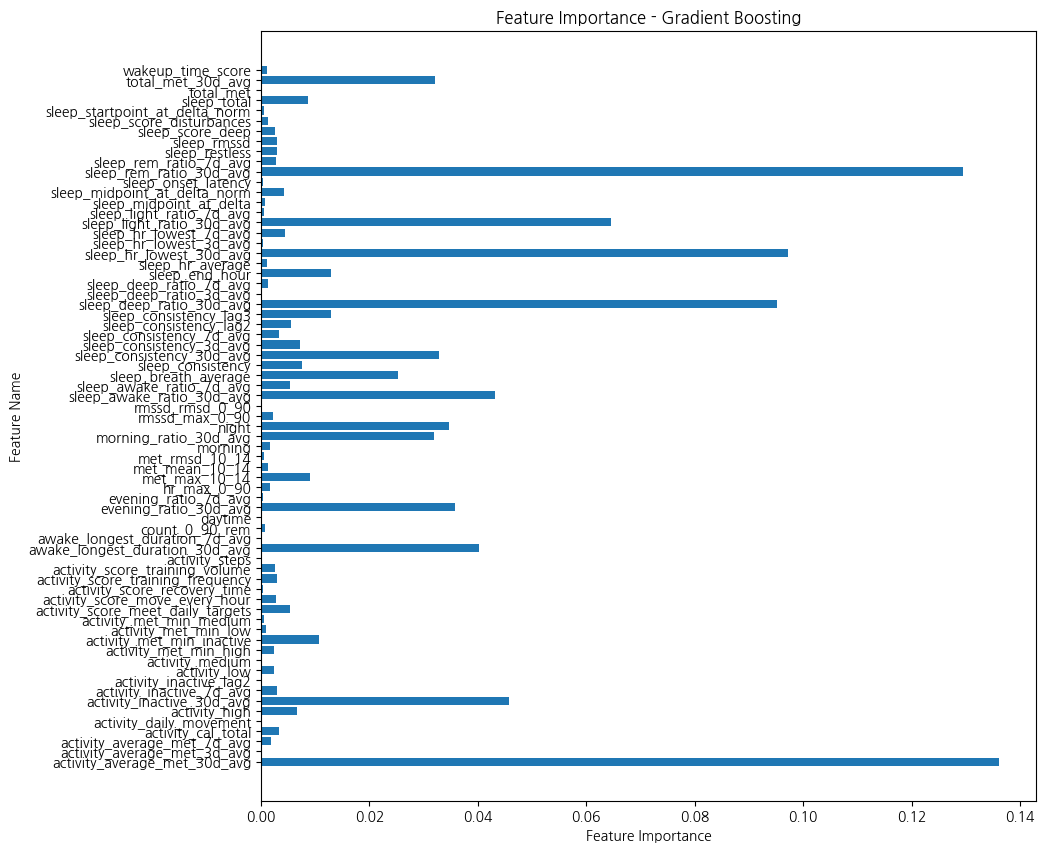

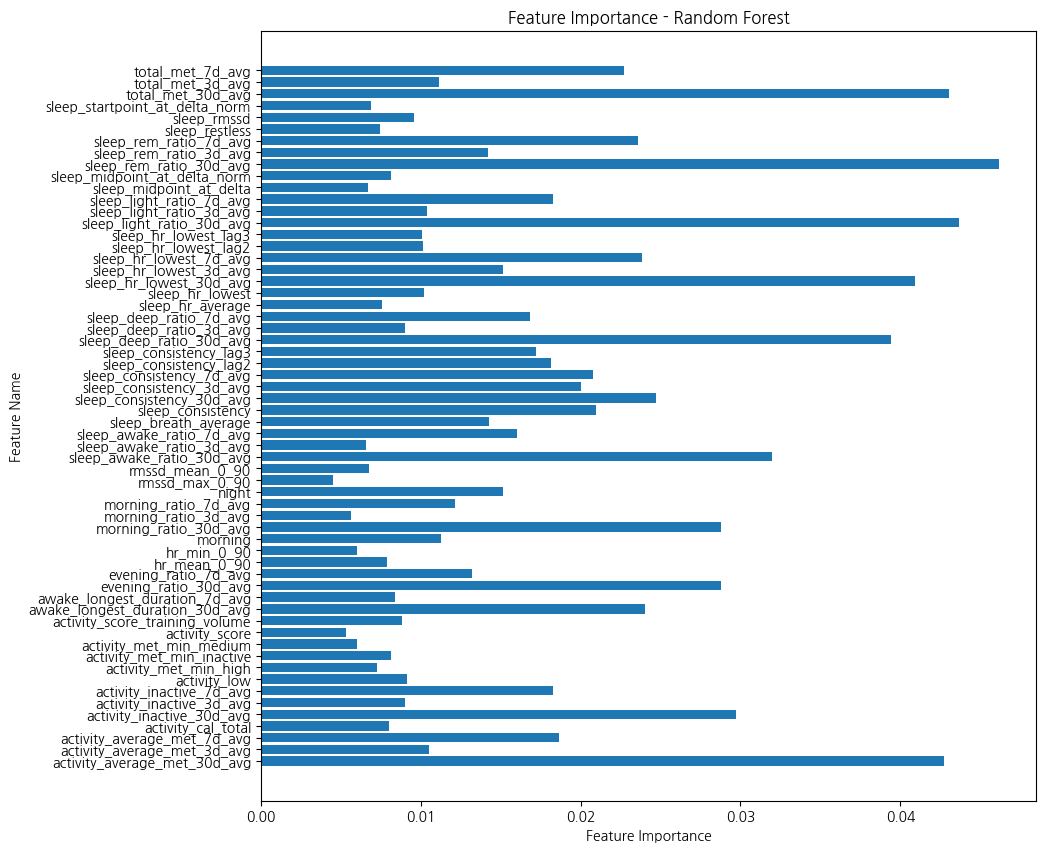

In [28]:
low_importances = []

for name, model in models_.items():
    feature_importances = model.feature_importances_
    features = selected_features_dict[name]

    plt.figure(figsize=(10, 10))
    plt.barh(features, feature_importances)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title(f"Feature Importance - {name}")
    plt.show()

# 모델 저장

In [171]:
with open("case5_model", "wb") as f:
    pickle.dump(model_, f)